## Quiz 1: Modelos de Regresión

### 1. Importación, limpieza y visualización de la matriz de datos

In [25]:
import csv
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

with open('data.csv', newline='') as csvfile:
    reader = csv.reader(csvfile)
    csv_data = [row for row in reader]
numeric_data = []
for row in csv_data[1:]:
    clean_row = [cell.replace('\u200b', '').strip() for cell in row]
    try:
        numeric_row = [float(cell) for cell in clean_row]
        numeric_data.append(numeric_row)
    except ValueError:
        continue # Skip rows that cannot be converted

data = sp.Matrix(numeric_data)
data

Matrix([
[0.1, 0.1],
[1.0, 1.1],
[2.0, 1.3],
[3.0, 2.5],
[4.0, 4.2],
[5.0, 6.8],
[6.0, 8.8]])

### 2. Visualización Gráfica de los Datos

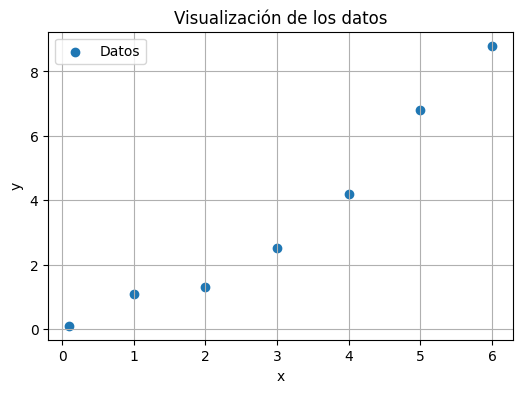

In [26]:
plt.figure(figsize=(6, 4))
plt.scatter(data[:, 0], data[:, 1], label='Datos')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Visualización de los datos')
plt.legend()
plt.grid(True)
plt.show()


### 3. Escoger la función para la tendencia de los datos

In [27]:
# Convertir la matriz de datos a lista de tuplas
def prepare_data(raw_data):
    if isinstance(raw_data, sp.Matrix):
        return [(float(raw_data[i, 0]), float(raw_data[i, 1])) for i in range(raw_data.rows)]
    elif isinstance(raw_data, (list, tuple)):
        return [(float(xi), float(yi)) for xi, yi in raw_data]
    else:
        raise TypeError("Formato de datos no reconocido: use lista de tuplas o Sympy Matrix")

#### a. Polinomial de Grado n

In [10]:
# Definir el modelo polinomial de grado n
n = 5
a = sp.symbols(f'a0:{n+1}')    # (a0, a1, ..., an)
x = sp.symbols('x')
model_poly = sum(a[i] * x**i for i in range(n+1))

data = prepare_data(data)

# Construir matriz A y vector y
def build_poly_system(data_list, degree):
    # A tendrá columnas [1, x, x^2, ..., x^degree]
    A = sp.Matrix([[xi**j for j in range(degree+1)] for xi, yi in data_list])
    y = sp.Matrix([yi for xi, yi in data_list])
    return A, y

A, y_vec = build_poly_system(data, n)

# Resolver sistema normal: (A^T A) * a_vec = A^T * y
AtA = A.T * A
Aty = A.T * y_vec

# Asegurarse de que AtA es invertible
if AtA.det() == 0:
    raise ValueError("La matriz A^T*A es singular para grado = {}.".format(n))

a_vec = AtA.inv() * Aty   # vector [a0, a1, ..., an]

# Mostrar resultados
for i, coeff in enumerate(a_vec):
    print(f"a{i} = {sp.simplify(coeff)}")

adjusted_model = sp.simplify(model_poly.subs({a[i]: a_vec[i] for i in range(n+1)}))

print("\nModelo ajustado:")
y = sp.symbols('y')
display(sp.Eq(y, adjusted_model))

a0 = 0.106493506492654
a1 = 1.95590909092607
a2 = -1.44886363640398
a3 = 0.501515151529020
a4 = -0.0556818181839844
a5 = 0.00166666666680726

Modelo ajustado:


Eq(y, 0.00166666666680726*x**5 - 0.0556818181839844*x**4 + 0.50151515152902*x**3 - 1.44886363640398*x**2 + 1.95590909092607*x + 0.106493506492654)

#### b. Exponencial

In [16]:
# Definir el modelo exponencial
B0, B1, x = sp.symbols('B0 B1 x')

data = prepare_data(data)
# Transformación log y montar sistema lineal
data_log = [(xi, np.log(yi)) for xi, yi in data]
A = sp.Matrix([[xi, 1] for xi, _ in data_log])
y_vec = sp.Matrix([yi for _, yi in data_log])

# Resolver normales ln y = B0 + B1 x
AtA = A.T * A
Aty = A.T * y_vec
B_vec = AtA.inv() * Aty
B1_val = float(B_vec[0])
B0_val = float(B_vec[1])
A_val  = np.exp(B0_val)

# Modelo simbólico original
adjusted_model = A_val * sp.exp(B1_val * x)

print("\nModelo ajustado:")
y = sp.symbols('y')
display(sp.Eq(y, adjusted_model))


Modelo ajustado:


Eq(y, 0.263986728811299*exp(0.655030050681627*x))

#### c. Logarítmica

In [22]:
# 1. Definir símbolos y modelo
C0, C1, x = sp.symbols('C0 C1 x')
model_logarithmic = C0 + C1*sp.log(x)

# 2. Preparar datos
data = prepare_data(data)  # usa la misma prepare_data que ya definiste

# 3. Transformar x -> ln(x) y montar sistema lineal
#    modelo: y = C0 + C1 * ln(x)  ==>  columna [ln(x), 1]
A = sp.Matrix([[np.log(xi), 1] for xi, yi in data])
y_vec = sp.Matrix([yi for xi, yi in data])

# 4. Resolver las ecuaciones normales: (A^T A)·[C1, C0]^T = A^T·y
AtA = A.T * A
Aty = A.T * y_vec

if AtA.det() == 0:
    raise ValueError("A^T*A es singular en el modelo logarítmico.")

C_vec = AtA.inv() * Aty  # [C1, C0]
C1_val = float(C_vec[0])
C0_val = float(C_vec[1])

# 5. Modelo ajustado simbólico
adjusted_model = model_logarithmic.subs({C0: C0_val, C1: C1_val})

print("\nModelo ajustado:")
y = sp.symbols('y')
display(sp.Eq(y, sp.simplify(adjusted_model)))


Modelo ajustado:


Eq(y, 1.71914233996683*log(x) + 2.49254317155684)

#### d. Potencial

In [31]:
# Definir símbolos y modelo (transformado)
P0, P1, x = sp.symbols('P0 P1 x')
# Transformación: ln y = ln P0 + P1 * ln x
B0, B1 = sp.symbols('B0 B1')
model_log = B0 + B1*sp.log(x)

# Preparar datos
data = prepare_data(data)  # tu lista de tuplas o Sympy Matrix

# Transformar datos: (u = ln x, v = ln y)
data_log = [(np.log(xi), np.log(yi)) for xi, yi in data]
A = sp.Matrix([[ui, 1] for ui, vi in data_log])
y_vec = sp.Matrix([vi for ui, vi in data_log])

# Resolver sistema normal: (A^T A)·[B1, B0]^T = A^T·v
AtA = A.T * A
Aty = A.T * y_vec

if AtA.det() == 0:
    raise ValueError("A^T*A es singular en el modelo potencial.")

B_vec = AtA.inv() * Aty
B1_val = float(B_vec[0])   # = P1
B0_val = float(B_vec[1])   # = ln P0
P1_val = B1_val
P0_val = np.exp(B0_val)

print(f"P0 = {P0_val:.6f}, P1 = {P1_val:.6f}")

# Modelo ajustado simbólico
adjusted_model = P0_val * x**P1_val
print("\nModelo ajustado:")
y = sp.symbols('y')
display(sp.Eq(y, sp.simplify(adjusted_model)))

P0 = 1.000607, P1 = 1.050793

Modelo ajustado:


Eq(y, 1.00060724534419*x**1.05079269452626)

### 4. Visualización y Análisis de Resultados

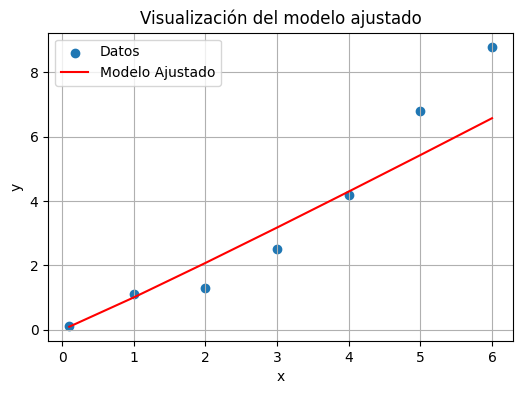

In [32]:
# Visualizar el modelo ajustado
plt.figure(figsize=(6, 4))
plt.scatter([xi for xi, yi in data], [yi for xi, yi in data], label='Datos')
x_vals = [xi for xi, yi in data]
y_vals = [adjusted_model.subs(x, xi) for xi in x_vals]
plt.plot(x_vals, y_vals, color='red', label='Modelo Ajustado')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Visualización del modelo ajustado')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# Evaluar el modelo ajustado
# Calcular R cuadrado (Coeficiente de determinación)
y_actual = [yi for xi, yi in data]
y_predicted = [adjusted_model.subs(x, xi) for xi, yi in data]

# Suma total de cuadrados (SST)
sst = sum((yi - sp.Rational(sum(y_actual) / len(y_actual)))**2 for yi in y_actual)

# Suma de cuadrados residuales (SSR)
ssr = sum((yi - y_pred)**2 for yi, y_pred in zip(y_actual, y_predicted))

# R cuadrado
r_squared = 1 - (ssr / sst)

# Calcular el Error Cuadrático Medio (ECM)
ecm = ((sum((yi - y_pred)**2 for yi, y_pred in zip(y_actual, y_predicted)) / len(y_actual))** 0.5)

print(f"R cuadrado: {r_squared}")
print(f"ECM: {ecm}")

R cuadrado: 0.873876446892922
ECM: 1.06217408732927
